In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE
import warnings



In [3]:
#Collect Data and then Preprocess it
data = pd.read_csv('UCI_Credit_Card.csv')

data = data[data['MARRIAGE'].isin([1,2,3])]
data = data[data['EDUCATION'].isin([1,2,3,4,5,6])]
data = data[data['SEX'].isin([1,2])]

pay_list = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for pay in pay_list:
  # -2 is assumed to be no credit to pay
  # -1 is credit paid fully
  # 0 is assumed to be payment made on time (minimum satement)
  data = data[data[pay].isin(range(-2,10))]

In [4]:
#Data Preprocessing
cat_cols = ['MARRIAGE']
data[cat_cols] = data[cat_cols].astype('category')
data = pd.get_dummies(data, columns=cat_cols, dtype=int)

x = data.drop('default.payment.next.month', axis=1)
y = data['default.payment.next.month']
smote = SMOTE(sampling_strategy='minority', random_state=42)
x,y=smote.fit_resample(x,y)
data = pd.concat([x, y], axis=1)



In [5]:
#Standardize/Normalzie data
scaler = StandardScaler()
num_cols = ['LIMIT_BAL','AGE'] + [f'BILL_AMT{i}' for i in range(1,7)] + [f'PAY_AMT{i}' for i in range(1,7)]
data[num_cols].describe().T[['mean', 'std']]
data[num_cols] = scaler.fit_transform(data[num_cols])
data[num_cols].describe().T[['mean', 'std']]

,mean,std
LIMIT_BAL,-7.318581e-17,1.000011
AGE,4.391149e-17,1.000011
BILL_AMT1,6.952652e-17,1.000011
BILL_AMT2,9.880084e-17,1.000011
BILL_AMT3,1.951622e-17,1.000011
BILL_AMT4,-2.515762e-17,1.000011
BILL_AMT5,9.026250e-17,1.000011
BILL_AMT6,2.317551e-17,1.000011
PAY_AMT1,1.707669e-17,1.000011
PAY_AMT2,-2.439527e-18,1.000011


In [6]:
#Prepare data for clustering
# Separate features from target variable
X_scaled = data.drop('default.payment.next.month', axis=1)

# Display feature information
print("Features for clustering:")
print(X_scaled.columns.tolist())
print(f"Number of features: {len(X_scaled.columns)}")



Features for clustering:
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']
Number of features: 26


In [7]:
#Determine optimal number of clusters using Elbow Method
# Wccs = Within-Cluster-Sum-of-Squares
wcss = [] 
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score
    # Silhouette score requires at least 2 clusters
    if k > 1:  
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

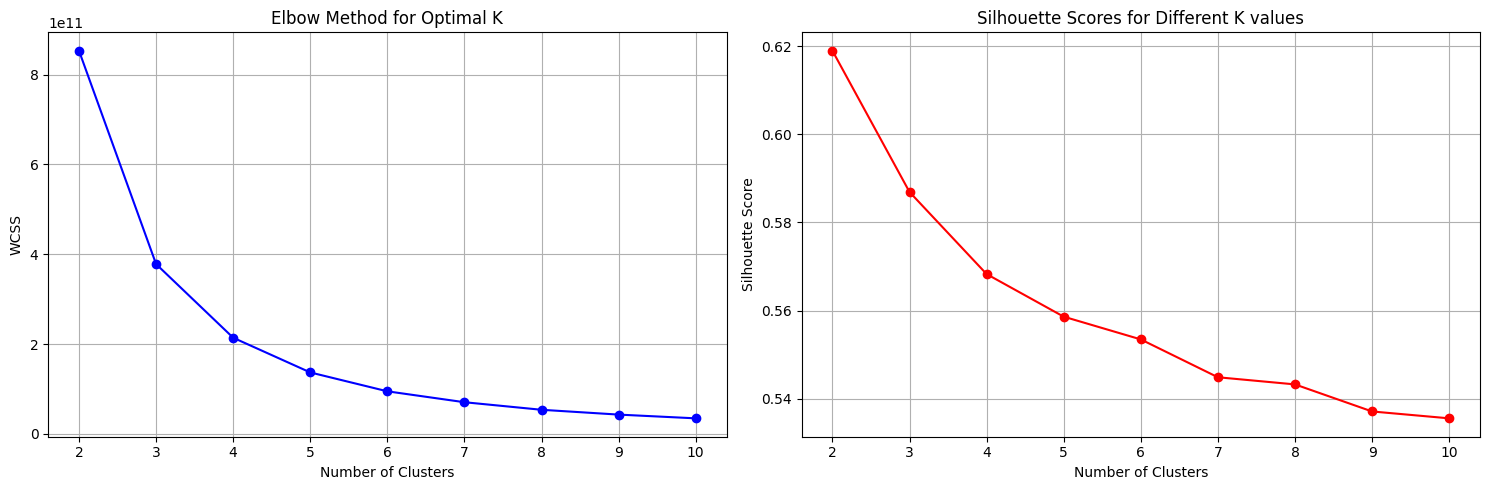

K=2: Silhouette Score = 0.6190
K=3: Silhouette Score = 0.5869
K=4: Silhouette Score = 0.5683
K=5: Silhouette Score = 0.5586
K=6: Silhouette Score = 0.5534
K=7: Silhouette Score = 0.5449
K=8: Silhouette Score = 0.5432
K=9: Silhouette Score = 0.5371
K=10: Silhouette Score = 0.5355


In [8]:
# Plot Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, wcss, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K values')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print silhouette scores
for k, score in zip(range(2, 11), silhouette_scores):
    print(f"K={k}: Silhouette Score = {score:.4f}")

In [9]:
# Perform K-means clustering with chosen K
# Based on elbow plot and silhouette scores, choose optimal K
optimal_k = 3  

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df_with_clusters = data.copy()
df_with_clusters['Cluster'] = clusters

print("Cluster distribution:")
print(df_with_clusters['Cluster'].value_counts().sort_index())

Cluster distribution:
Cluster
0    16005
1    15763
2    14834
Name: count, dtype: int64


Cluster Profiles (mean values):


,ID,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
Cluster,,,,,,,,,,,,,,,,,,,,,
0,15111.957763,-0.058265,1.533771,1.768885,-0.025748,0.250859,0.134146,0.065042,0.025617,-0.036863,...,0.014482,-0.017466,-0.003931,-0.009170,0.000035,-0.000058,-0.011104,0.376007,0.420181,0.006623
1,5291.288207,0.004439,1.487978,1.720041,-0.021046,0.172556,0.002538,-0.018524,-0.113176,-0.128085,...,-0.028950,-0.005264,-0.010953,-0.038988,-0.010456,0.003280,-0.002567,0.365984,0.451944,0.007993
2,24839.531414,0.058147,1.496899,1.807335,0.050144,0.089322,-0.025482,-0.082850,-0.121613,-0.201227,...,0.015138,0.024438,0.015880,0.051323,0.011073,-0.003423,0.014709,0.390050,0.433261,0.006202


<Figure size 2000x1200 with 0 Axes>

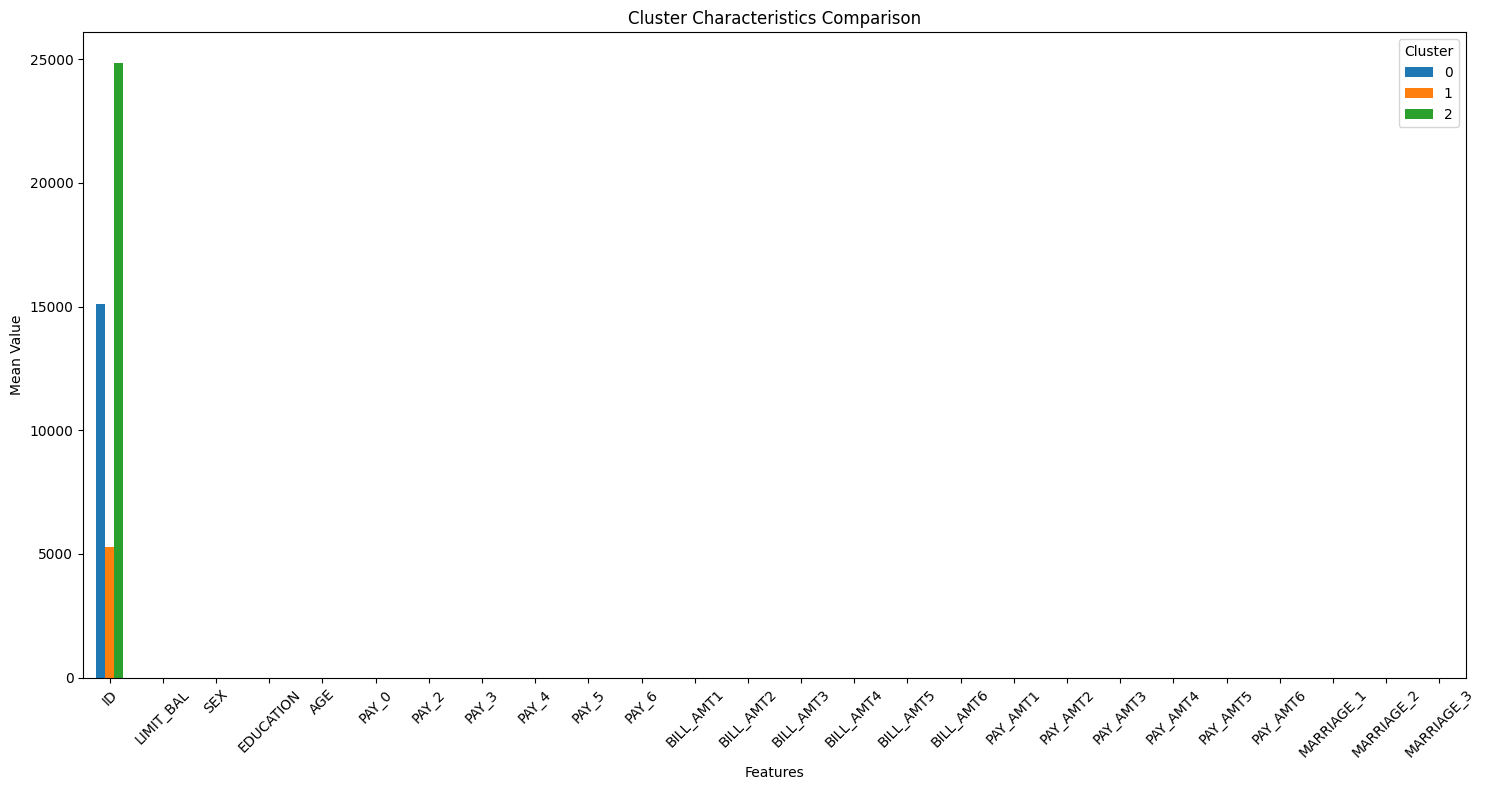

In [10]:
# Analyze cluster characteristics
# Create a copy of the scaled data with cluster labels
X_analyze = X_scaled.copy()
X_analyze['Cluster'] = clusters

# Calculate mean values for each cluster
cluster_profile = X_analyze.groupby('Cluster').mean()

print("Cluster Profiles (mean values):")
display(cluster_profile)

# Visualize cluster characteristics
plt.figure(figsize=(20, 12))
cluster_profile.T.plot(kind='bar', figsize=(15, 8))
plt.title('Cluster Characteristics Comparison')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Explained variance ratio: [9.99999667e-01 1.03960409e-07]
Total explained variance: 1.0000


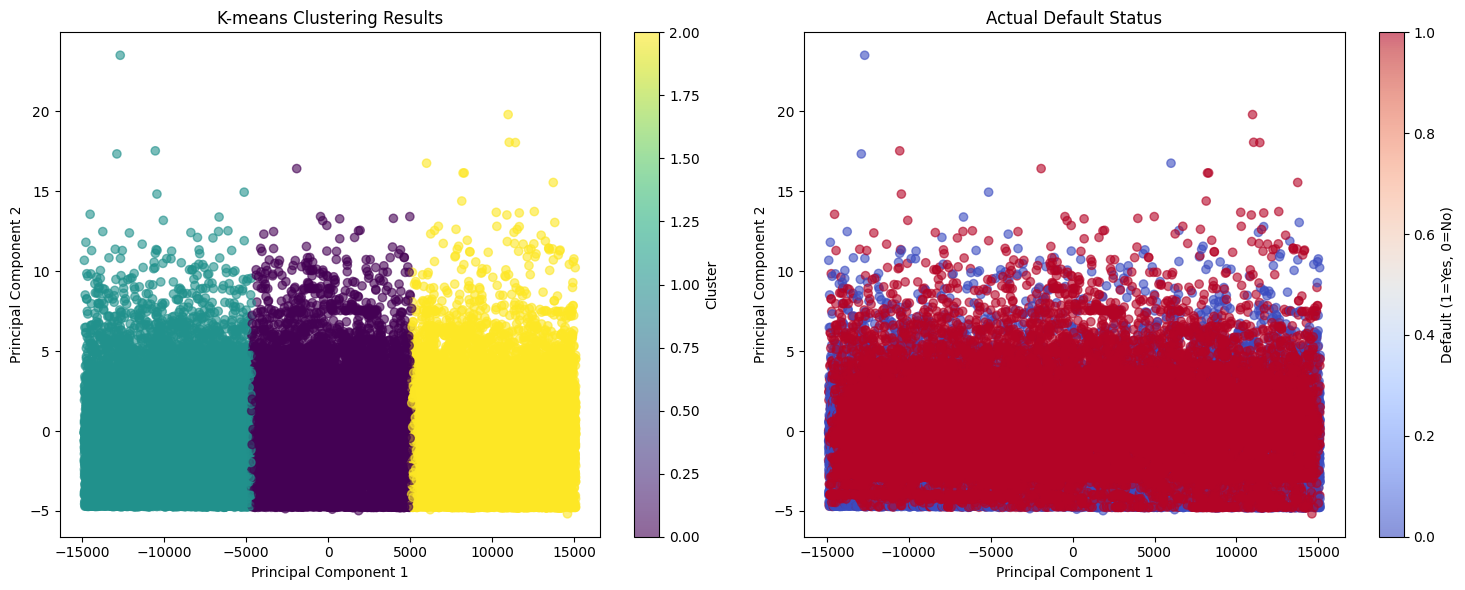

In [12]:
# Visualize clusters using PCA
# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
pca_df['Default'] = data['default.payment.next.month']

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

# Plot clusters
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], 
                     cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering Results')
plt.colorbar(scatter, label='Cluster')

plt.subplot(1, 2, 2)
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Default'], 
                     cmap='coolwarm', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Actual Default Status')
plt.colorbar(scatter, label='Default (1=Yes, 0=No)')

plt.tight_layout()
plt.show()

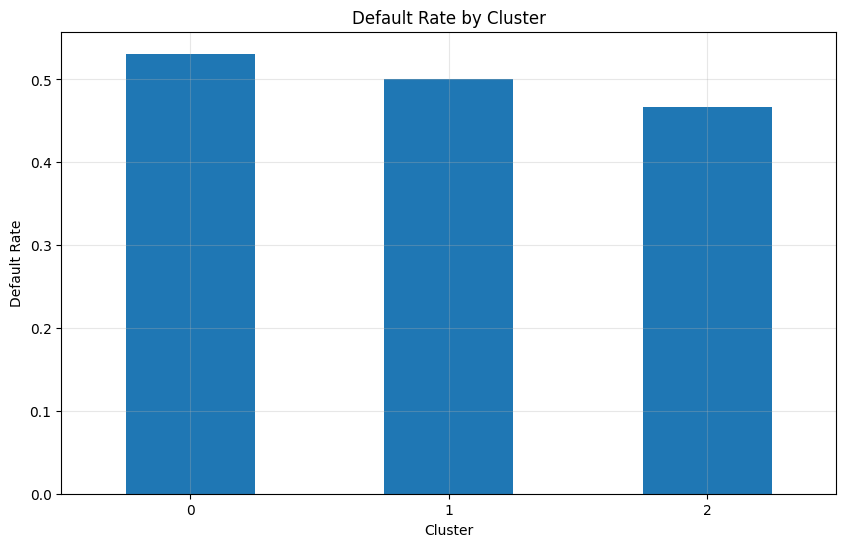

Default rates by cluster:
Cluster 0: 0.5311 (53.11%)
Cluster 1: 0.5000 (50.00%)
Cluster 2: 0.4664 (46.64%)


In [14]:
# Compare clusters with actual default rates
cluster_default_rates = df_with_clusters.groupby('Cluster')['default.payment.next.month'].mean()

plt.figure(figsize=(10, 6))
cluster_default_rates.plot(kind='bar')
plt.title('Default Rate by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Default Rate')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

print("Default rates by cluster:")
for cluster, rate in cluster_default_rates.items():
    print(f"Cluster {cluster}: {rate:.4f} ({rate*100:.2f}%)")

In [22]:
# Apply Elliptic Envelope for Outlier Detection
contamination_levels = [0.01, 0.05, 0.1]  # 1%, 5%, 10% expected outliers

X = data.drop('default.payment.next.month', axis=1)
y = data['default.payment.next.month']

print(len(data))

outlier_results = {}

for contamination in contamination_levels:
    print(f"\n--- Testing contamination = {contamination} ---")
    
    # Initialize Elliptic Envelope
    ee = EllipticEnvelope(contamination=contamination, random_state=42)
    
    # Fit and predict outliers (-1 for outliers, 1 for inliers)
    outlier_labels = ee.fit_predict(X_scaled)
    
    # Convert to binary (1 for inliers, -1 for outliers -> 0 for inliers, 1 for outliers)
    outliers = (outlier_labels == -1).astype(int)
    
    n_outliers = np.sum(outliers)
    outlier_percentage = (n_outliers / len(X)) * 100
    
    print(f"Number of outliers detected: {n_outliers}")
    print(f"Percentage of outliers: {outlier_percentage:.2f}%")
    
    outlier_results[contamination] = {
        'model': ee,
        'labels': outliers,
        'n_outliers': n_outliers,
        'percentage': outlier_percentage
    }


46602
46602

--- Testing contamination = 0.01 ---
Number of outliers detected: 467
Percentage of outliers: 1.00%

--- Testing contamination = 0.05 ---
Number of outliers detected: 2331
Percentage of outliers: 5.00%

--- Testing contamination = 0.1 ---
Number of outliers detected: 4661
Percentage of outliers: 10.00%


In [23]:
chosen_contamination = 0.1
final_outliers = outlier_results[chosen_contamination]['labels']

df_analysis = data.copy()
df_analysis['Outlier'] = final_outliers
df_analysis['Outlier_Label'] = df_analysis['Outlier'].map({0: 'Inlier', 1: 'Outlier'})

print("Creating PCA visualization...")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_analysis['PCA1'] = X_pca[:, 0]
df_analysis['PCA2'] = X_pca[:, 1]

print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum():.4f}")

plt.figure(figsize=(15, 5))


Creating PCA visualization...
PCA Explained Variance: 1.0000


<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

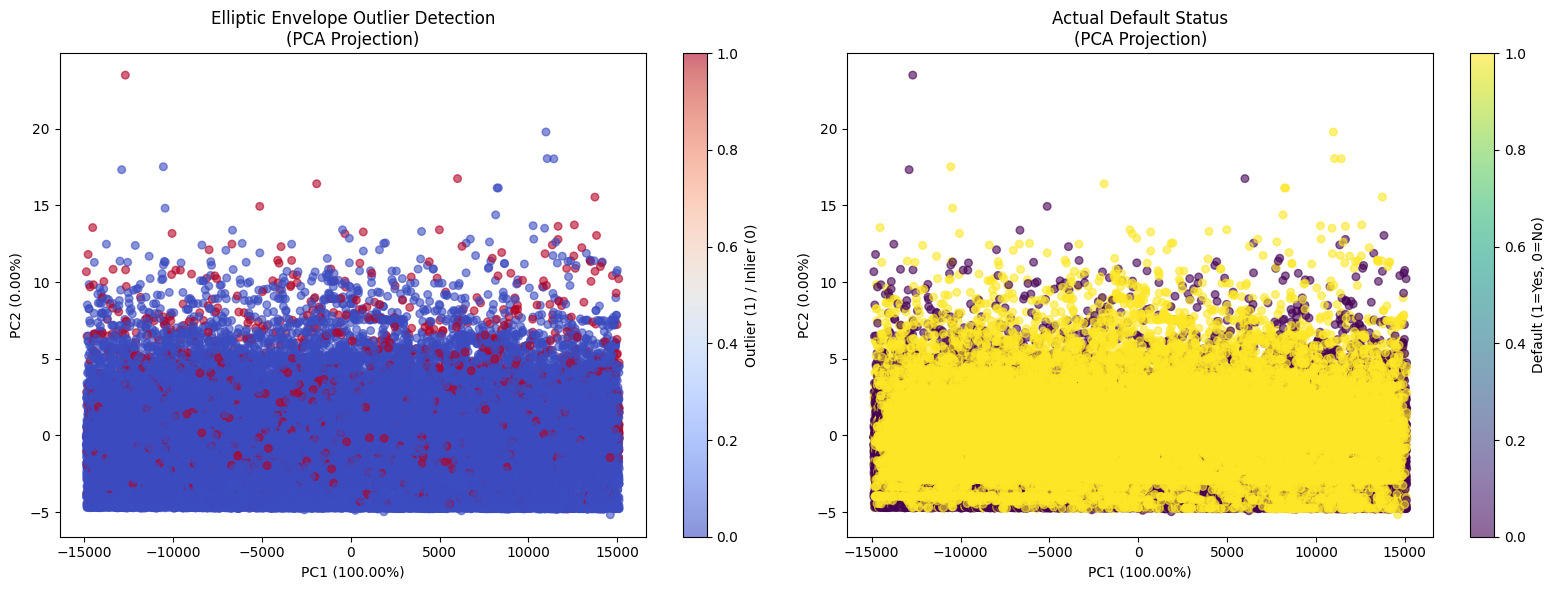

In [29]:
# Plot results in PCA
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Outlier visualization
scatter1 = axes[0].scatter(df_analysis['PCA1'], df_analysis['PCA2'], 
                          c=df_analysis['Outlier'], cmap='coolwarm', 
                          alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('Elliptic Envelope Outlier Detection\n(PCA Projection)')
plt.colorbar(scatter1, ax=axes[0], label='Outlier (1) / Inlier (0)')

# Default status for comparison
scatter2 = axes[1].scatter(df_analysis['PCA1'], df_analysis['PCA2'], 
                          c=df_analysis['default.payment.next.month'], cmap='viridis', 
                          alpha=0.6, s=30)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title('Actual Default Status\n(PCA Projection)')
plt.colorbar(scatter2, ax=axes[1], label='Default (1=Yes, 0=No)')

plt.tight_layout()
plt.show()